In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

stock_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
stock_ts = stock_data['Close']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
scaler = MinMaxScaler()
stock_normalized = scaler.fit_transform(stock_ts.values.reshape(-1, 1))

train_size = int(len(stock_normalized) * 0.67)
test_size = len(stock_normalized) - train_size
train, test = stock_normalized[0:train_size], stock_normalized[train_size:]

In [ ]:
def create_lstm_dataset(data, sequence_length):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [ ]:
sequence_length = 12
trainX, trainY = create_lstm_dataset(train, sequence_length)
testX, testY = create_lstm_dataset(test, sequence_length)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
def build_lstm_model(sequence_length, hidden_dim=32, num_layers=2, learning_rate=0.01):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(hidden_dim, input_shape=(sequence_length, 1), return_sequences=True))
        elif i == num_layers - 1:
            model.add(LSTM(hidden_dim))
        else:
            model.add(LSTM(hidden_dim, return_sequences=True))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
class StopTrainingOnValLoss(Callback):
    def __init__(self, monitor='val_loss', threshold=0.001):
        super(StopTrainingOnValLoss, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get(self.monitor)
        if current_val_loss is not None and current_val_loss < self.threshold:
            print(f"\nval_loss reached below {self.threshold}")
            self.model.stop_training = True

model = build_lstm_model(sequence_length, hidden_dim=32, num_layers=2, learning_rate=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
stop_training_on_val_loss = StopTrainingOnValLoss(monitor='val_loss', threshold=0.001)
history = model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2, validation_split=0.1,
                    callbacks=[early_stopping, stop_training_on_val_loss])
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/1000

val_loss reached below 0.001
595/595 - 5s - loss: 0.0035 - val_loss: 8.5783e-04 - 5s/epoch - 8ms/step
10/10 [==============================] - 1s 2ms/step


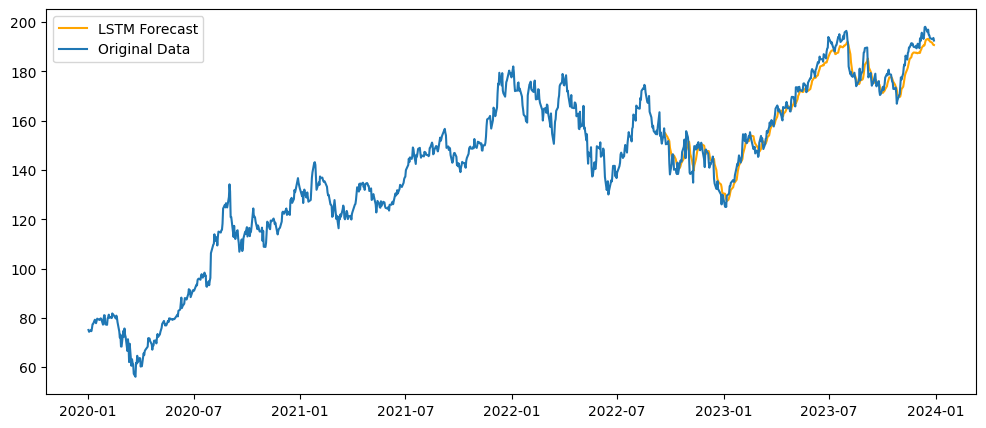

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(stock_ts.index[train_size+sequence_length:], testPredict, label='LSTM Forecast', color='orange')
plt.plot(stock_ts, label='Original Data')
plt.legend()
plt.show()

In [ ]:
future_steps = 10
future_predictions_lstm = []
current_input = testX[-1:]

for i in range(future_steps):
    next_prediction = model.predict(current_input)
    future_predictions_lstm.append(next_prediction[0, 0])
    current_input = np.roll(current_input, -1, axis=1)
    current_input[0, -1] = next_prediction

future_predictions_lstm = np.array(future_predictions_lstm)
future_predictions_lstm = scaler.inverse_transform(future_predictions_lstm.reshape(-1, 1))

print("Forecasted values:")
print(future_predictions_lstm.flatten())

1/1 [==============================] - 0s 15ms/step
Forecasted values:
[190.69867 189.84445 188.99188 188.1581  187.36714 186.6235  185.9088
 185.23422 184.5862  183.96628]


In [ ]:
from tensorflow.keras.layers import Bidirectional

def build_bilstm_model(sequence_length, hidden_dim=32, num_layers=2, learning_rate=0.01):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True), input_shape=(sequence_length, 1)))
        elif i == num_layers - 1:
            model.add(Bidirectional(LSTM(hidden_dim)))
        else:
            model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
bilstm_model = build_bilstm_model(sequence_length, hidden_dim=32, num_layers=2, learning_rate=0.01)
bilstm_history = bilstm_model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2, validation_split=0.1,
                                  callbacks=[early_stopping, stop_training_on_val_loss])
bilstm_testPredict = bilstm_model.predict(testX)
bilstm_testPredict = scaler.inverse_transform(bilstm_testPredict)

Epoch 1/1000
595/595 - 8s - loss: 0.0052 - val_loss: 0.0015 - 8s/epoch - 14ms/step
Epoch 2/1000
595/595 - 5s - loss: 0.0013 - val_loss: 0.0014 - 5s/epoch - 8ms/step
Epoch 3/1000

val_loss reached below 0.001
595/595 - 4s - loss: 0.0012 - val_loss: 6.8071e-04 - 4s/epoch - 7ms/step
10/10 [==============================] - 1s 3ms/step


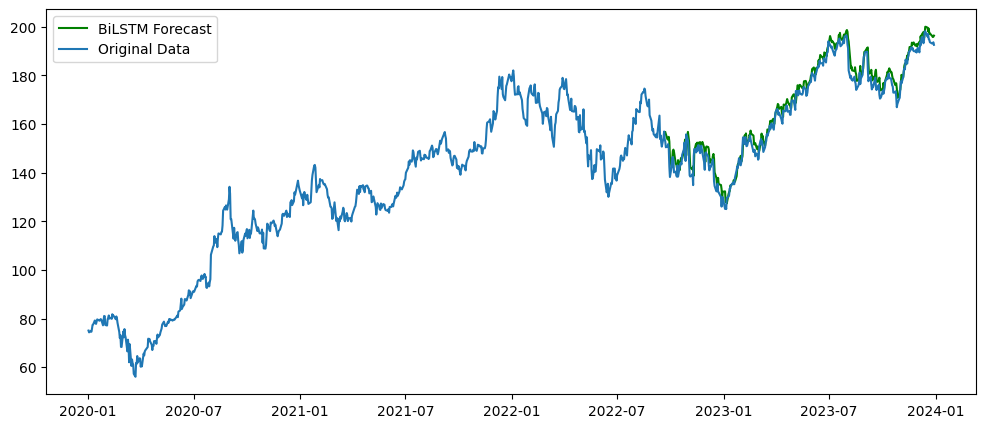

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(stock_ts.index[train_size+sequence_length:], bilstm_testPredict, label='BiLSTM Forecast', color='green')
plt.plot(stock_ts, label='Original Data')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import Flatten

def build_ann_model(sequence_length, num_neurons=64, learning_rate=0.01):
    model = Sequential()
    model.add(Flatten(input_shape=(sequence_length, 1)))
    model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
ann_model = build_ann_model(sequence_length, num_neurons=64, learning_rate=0.01)
ann_history = ann_model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2, validation_split=0.1,
                            callbacks=[early_stopping, stop_training_on_val_loss])

ann_testPredict = ann_model.predict(testX)
ann_testPredict = scaler.inverse_transform(ann_testPredict)

Epoch 1/1000
595/595 - 1s - loss: 0.0043 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 2/1000
595/595 - 1s - loss: 0.0020 - val_loss: 0.0029 - 573ms/epoch - 962us/step
Epoch 3/1000
595/595 - 1s - loss: 0.0017 - val_loss: 0.0022 - 592ms/epoch - 996us/step
Epoch 4/1000

val_loss reached below 0.001
595/595 - 1s - loss: 0.0011 - val_loss: 7.4588e-04 - 602ms/epoch - 1ms/step
10/10 [==============================] - 0s 1ms/step


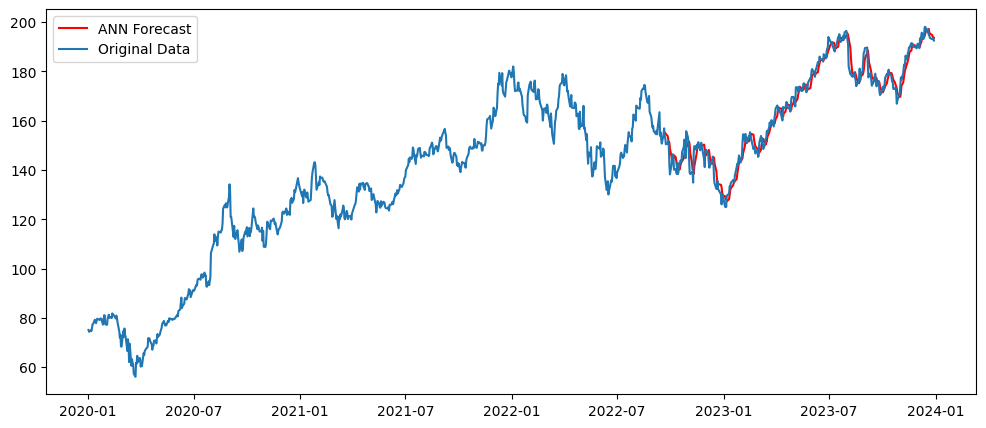

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(stock_ts.index[train_size+sequence_length:], ann_testPredict, label='ANN Forecast', color='red')
plt.plot(stock_ts, label='Original Data')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions, targets))

lstm_rmse = calculate_rmse(testPredict.flatten(), testY.flatten())
print("RMSE for LSTM model:", lstm_rmse)

bilstm_rmse = calculate_rmse(bilstm_testPredict.flatten(), testY.flatten())
print("RMSE for BiLSTM model:", bilstm_rmse)

ann_rmse = calculate_rmse(ann_testPredict.flatten(), testY.flatten())
print("RMSE for ANN model:", ann_rmse)

RMSE for LSTM model: 3.7698829997670056
RMSE for BiLSTM model: 3.525404079578156
RMSE for ANN model: 3.3184552899908306


In [ ]:
future_steps = 10
future_predictions_lstm = []
future_predictions_bilstm = []
future_predictions_ann = []

current_input_lstm = testX[-1:]
current_input_bilstm = testX[-1:]
current_input_ann = testX[-1:]

for i in range(future_steps):
    # LSTM Model
    next_prediction_lstm = model.predict(current_input_lstm)
    future_predictions_lstm.append(next_prediction_lstm[0, 0])
    current_input_lstm = np.roll(current_input_lstm, -1, axis=1)
    current_input_lstm[0, -1] = next_prediction_lstm

    # BiLSTM Model
    next_prediction_bilstm = bilstm_model.predict(current_input_bilstm)
    future_predictions_bilstm.append(next_prediction_bilstm[0, 0])
    current_input_bilstm = np.roll(current_input_bilstm, -1, axis=1)
    current_input_bilstm[0, -1] = next_prediction_bilstm

    # ANN Model
    next_prediction_ann = ann_model.predict(current_input_ann)
    future_predictions_ann.append(next_prediction_ann[0, 0])
    current_input_ann = np.roll(current_input_ann, -1, axis=1)
    current_input_ann[0, -1] = next_prediction_ann

future_predictions_lstm = np.array(future_predictions_lstm)
future_predictions_bilstm = np.array(future_predictions_bilstm)
future_predictions_ann = np.array(future_predictions_ann)
future_predictions_lstm = scaler.inverse_transform(future_predictions_lstm.reshape(-1, 1))
future_predictions_bilstm = scaler.inverse_transform(future_predictions_bilstm.reshape(-1, 1))
future_predictions_ann = scaler.inverse_transform(future_predictions_ann.reshape(-1, 1))

print("Forecasted values (LSTM model):")
print(future_predictions_lstm.flatten())

print("Forecasted values (BiLSTM model):")
print(future_predictions_bilstm.flatten())

print("Forecasted values (ANN model):")
print(future_predictions_ann.flatten())

1/1 [==============================] - 0s 15ms/step
Forecasted values (LSTM model):
[190.69867 189.84445 188.99188 188.1581  187.36714 186.6235  185.9088
 185.23422 184.5862  183.96628]
Forecasted values (BiLSTM model):
[196.3127  198.90901 201.14735 203.12772 204.8718  206.38313 207.68512
 208.82324 209.83589 210.77278]
Forecasted values (ANN model):
[193.64754 193.62961 193.66669 193.71056 193.84898 193.6735  193.73033
 193.69916 193.70552 193.71986]


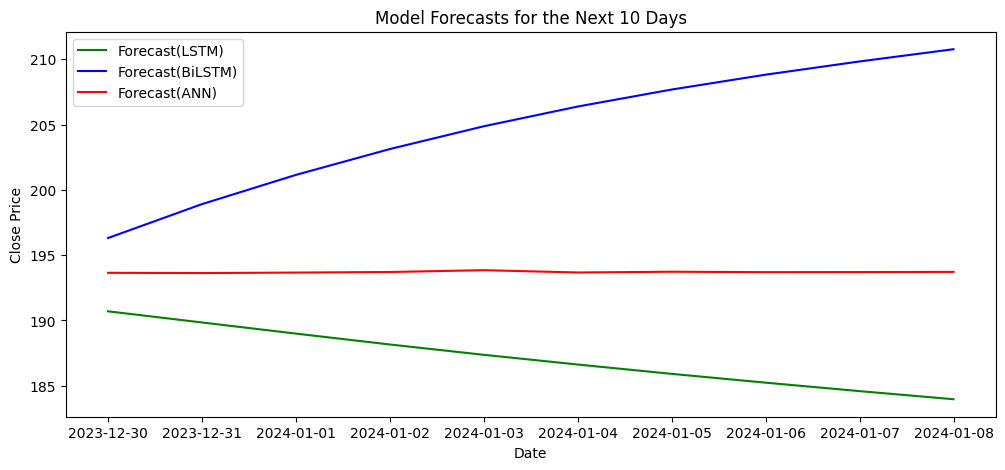

In [ ]:
future_dates = generate_future_dates(stock_ts.index[-1], future_steps)
future_df_lstm = pd.DataFrame({'Date': future_dates, 'Predicted': future_predictions_lstm.flatten()})
future_df_bilstm = pd.DataFrame({'Date': future_dates, 'Predicted': future_predictions_bilstm.flatten()})
future_df_ann = pd.DataFrame({'Date': future_dates, 'Predicted': future_predictions_ann.flatten()})

plt.figure(figsize=(12, 5))
plt.plot(future_df_lstm['Date'], future_df_lstm['Predicted'], label='Forecast(LSTM)', color='green')
plt.plot(future_df_bilstm['Date'], future_df_bilstm['Predicted'], label='Forecast(BiLSTM)', color='blue')
plt.plot(future_df_ann['Date'], future_df_ann['Predicted'], label='Forecast(ANN)', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Model Forecasts for the Next 10 Days')
plt.legend()
plt.show()

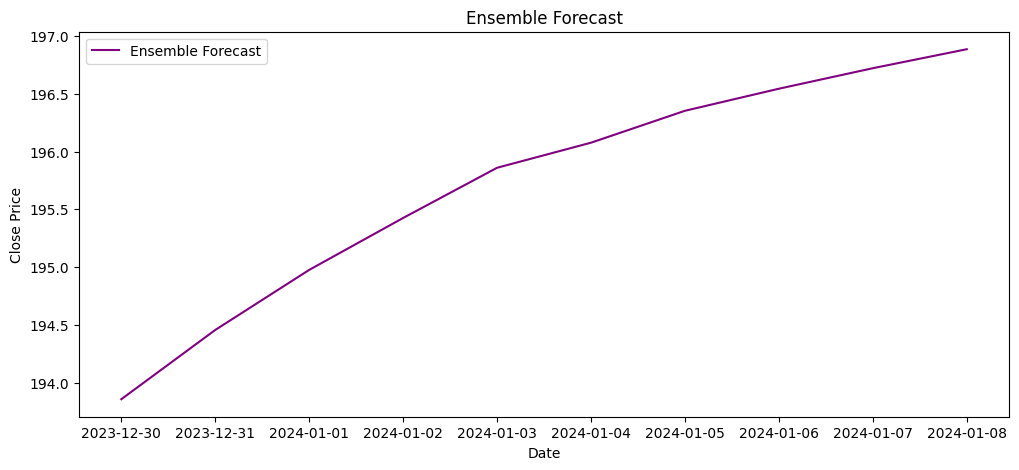

In [ ]:
weights = {
    'lstm': 0.2,
    'bilstm': 0.3,
    'ann': 0.5
}
ensemble_predictions_weighted = (future_predictions_lstm * weights['lstm'] +
                                 future_predictions_bilstm * weights['bilstm'] +
                                 future_predictions_ann * weights['ann'])

ensemble_df_weighted = pd.DataFrame({'Date': future_dates, 'Ensemble': ensemble_predictions_weighted.flatten()})

plt.figure(figsize=(12, 5))
plt.plot(ensemble_df_weighted['Date'], ensemble_df_weighted['Ensemble'], label='Ensemble Forecast', color='purple')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Ensemble Forecast')
plt.legend()
plt.show()